## Bag of Visual Words (BOVW)

Bag of visual words (BOVW) is commonly used in **image classification**. Its concept is adapted from information retrieval and NLP’s bag of words (BOW). In bag of words (BOW), we count the number of each word appears in a document, use the frequency of each word to know the keywords of the document, and make a frequency histogram from it. We have the same concept in bag of visual words (BOVW), but instead of words, we use **image features** as the “words”. Image features are unique pattern that we can find in an image.

The general idea of bag of visual words (BOVW) is to represent an image as a set of features. Features consists of keypoints and descriptors. Keypoints are the “stand out” points in an image, so no matter the image is rotated, shrink, or expand, its keypoints will always be the same. And descriptor is the description of the keypoint. We use the keypoints and descriptors to construct vocabularies and represent each image as a frequency histogram of features that are in the image. From the frequency histogram, later, we can find another similar images or predict the category of the image.

Detecting features and extracting descriptors in an image can be done by using feature extractor algorithms (for example, SIFT, KAZE, etc).

This Image classification with Bag of Visual Words technique has three steps:

1. **Feature Extraction**: Determination of Image features of a given label.
2. **Codebook Construction**: Construction of visual vocabulary by clustering, followed by frequency analysis.
3. **Classification**: Classification of images based on vocabulary generated using SVM.

### Feature Extraction

The first step to build a bag of visual words is to perform feature extraction by **extracting descriptors** from each image in our dataset.

Feature representation methods deal with how to represent the patches as numerical vectors. These vectors are called feature descriptors.

A good descriptor should have the ability to handle the intensity, rotation, scale and affine variations to some extent.

The most famous feature descriptors are Scale Invariant Feature Transform (SIFT), KAZE and ORB.

* SIFT converts each patch to **128-dimensional vector**. After this step, each image is a collection of vectors of the same dimension (128 for SIFT), where the order of different vectors is of no importance.

### Codewords and Codebook Construction

The vectors generated in the feature extraction step above are now converted into the codewords which is similar to words in text documents. Codewords are nothing but **vector representation of similar patches**. This codeword also produces a codebook is similar to a word dictionary

This step normally accomplished via the **K-Means Clustering** algorithm. The outline of the K-Means clustering is shown below

Given k:

1. Select initial centroids at random.
2. Assign each object to the cluster with the nearest centroid.
3. Compute each centroid as the mean of the objects assigned to it.
4. Repeat steps 2 and 3 until no change.

* Each cluster center produced by K-Means becomes a codeword.
* The number of clusters is the codebook size.
* Codebook can be learned on the separate training sets.
* The codebook is used for quantizing features. Quantization of features means that the Feature vector maps it to the index of the nearest codeword in a codebook.
* Each patch in an image is mapped to a certain codeword through the clustering process and the image can be represented by the histogram of the codewords.

![](https://machinelearningknowledge.ai/wp-content/uploads/2020/05/Bag-of-visual-words-Codebook-Construction.jpg?ezimgfmt=ng:webp/ngcb1)

### Classification

The next step consists of representing each image into a histogram of codewords.

* Apply the keypoint detector or feature extractor to every training image, then match every keypoint with those in the codebook.

* The result of this is a histogram where the bins correspond to the codewords, and the count of every bin corresponds to the number of times the corresponding codeword matches a keypoint in the given image. In this way, an image can be represented by a histogram of codewords.

The histograms of the training images can then be used to learn a classification model using SVM, KNN etc.

![](https://machinelearningknowledge.ai/wp-content/uploads/2020/05/Image-classification-with-bag-of-visual-words.jpg?ezimgfmt=ng:webp/ngcb1)

In [256]:
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import pylab as pl
from sklearn.metrics import confusion_matrix,accuracy_score

In [257]:
NUMBER_OF_SAMPLE_IMG = 5000
CAT = 0
DOG = 1

### Get Dataset

Get "dogs-vs-cats-redux-kernels-edition" dataset from Kaggle

In [258]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [259]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [260]:
! cp kaggle.json ~/.kaggle

In [261]:
! chmod 600 ~/.kaggle/kaggle.json

In [262]:
! kaggle competitions download dogs-vs-cats-redux-kernels-edition

dogs-vs-cats-redux-kernels-edition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [263]:
! pwd

/content


### Unzip dataset

In [264]:
current_directory = '/content/'

In [265]:
import zipfile

def unzip_file_to_current_directory(data_path):
  with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall(current_directory)

In [266]:
data_path = current_directory + 'dogs-vs-cats-redux-kernels-edition.zip'
train_data_path = current_directory + 'train.zip'
test_data_path = current_directory + 'test.zip'

In [267]:
unzip_file_to_current_directory(data_path)
unzip_file_to_current_directory(train_data_path)
unzip_file_to_current_directory(test_data_path)

In [268]:
train_data_path = current_directory + 'train/'
test_data_path  = current_directory + 'test/'

In [269]:
class_names = [CAT, DOG]

In [270]:
train_data = np.array(os.listdir(train_data_path))

In [271]:
train_data.shape

(25000,)

In [272]:
def get_cat_images_from_dataset(file_name):
  return 'cat' in file_name

def get_dog_images_from_dataset(file_name):
  return 'dog' in file_name

### Get Datapaths

In [273]:
train_img_paths_0 = np.array(list(filter(get_cat_images_from_dataset, train_data)))   # Cat images
train_img_paths_1 = np.array(list(filter(get_dog_images_from_dataset, train_data)))   # Dog images

In [274]:
def create_path(file_name):
  return (train_data_path + file_name)

In [275]:
train_img_paths_0 = list(map(create_path, train_img_paths_0))
train_img_paths_1 = list(map(create_path, train_img_paths_1))

In [276]:
# Get data from dataset as much as NUMBER_OF_SAMPLE_IMG
train_img_paths_0 = train_img_paths_0[:NUMBER_OF_SAMPLE_IMG]
train_img_paths_1 = train_img_paths_1[:NUMBER_OF_SAMPLE_IMG]

In [277]:
class_0 = np.full((1, NUMBER_OF_SAMPLE_IMG), CAT)
class_1 = np.full((1, NUMBER_OF_SAMPLE_IMG), DOG)

### All training image paths are in one list (img_paths)

In [278]:
img_paths = train_img_paths_0 + train_img_paths_1

### All image classes are in one list (img_classes)

In [280]:
img_classes = np.concatenate((class_0, class_1), axis=1)
img_classes = list(img_classes.reshape((10000,)))

In [281]:
dataset_hold = []
for i in range(len(img_paths)):
  dataset_hold.append((img_paths[i], img_classes[i]))

In [282]:
random.shuffle(dataset_hold)

In [283]:
train_hold = dataset_hold[:4000]
valid_hold = dataset_hold[4000:]

In [284]:
train_img_paths, y_train = zip(*train_hold)
valid_img_paths, y_valid = zip(*valid_hold)

### Plot sample Image

In [285]:
sample_img = cv2.imread(train_img_paths_0[20])

In [286]:
sample_img = cv2.resize(sample_img, (150, 150))

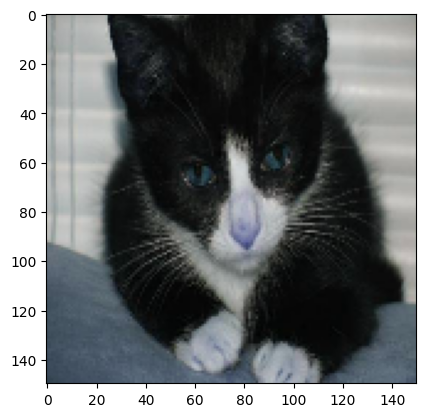

In [287]:
plt.imshow(sample_img)

### Feature Extraction using ORB

ORB is a fusion of **FAST** keypoint detector and **BRIEF** descriptor with some added features to improve the performance. FAST is Features from Accelerated Segment Test used to detect features from the provided image. It also uses a pyramid to produce multiscale-features. Now it doesn’t compute the orientation and descriptors for the features, so this is where BRIEF comes in the role.

ORB is an efficient alternative to SIFT or SURF algorithms used for feature extraction, in computation cost, matching performance, and mainly the patents. SIFT and SURF are patented and you are supposed to pay them for its use. But ORB is not patented. 

In [288]:
orb = cv2.ORB_create()

In [289]:
keypoint = orb.detect(sample_img, None)
keypoint, des = orb.compute(sample_img, keypoint)

### Plotting Keypoints

In [290]:
def draw_keypoints(img, keypoints, point_color = (0,255,255)):
  for kp in keypoints:
    x, y = kp.pt
    plt.imshow(cv2.circle(img, (int(x), int(y)), 2, point_color))

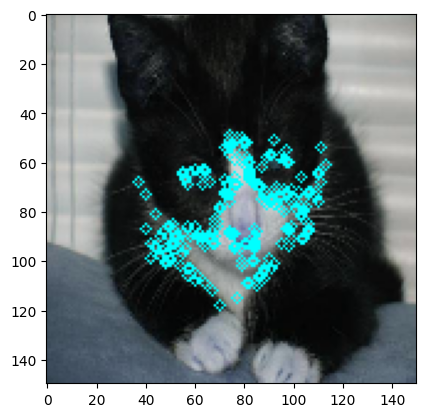

In [291]:
img = draw_keypoints(sample_img, keypoints=keypoint)

### Appending descriptors of the training images in list

### Create destination List

In [292]:
dest_list = []

In [293]:
orb = cv2.ORB_create(edgeThreshold=15)  # Change default edgeThreshold from 31 to 15 due to no descriptor problem in some images

### ORB Detect and compute for Training Set

In [294]:
for img_path in train_img_paths:
  im = cv2.imread(img_path)
  # im = cv2.resize(im, (150, 150))
  keypoints, descriptor = orb.detectAndCompute(im, None)
  dest_list.append((img_path, descriptor))

In [295]:
dest_list[0]

('/content/train/dog.5482.jpg',
 array([[228, 118, 185, ..., 251,  86,  97],
        [109, 205, 177, ..., 250, 195,  40],
        [190, 142,  99, ..., 125, 252, 138],
        ...,
        [ 82, 153, 159, ...,  64, 165,  59],
        [ 33,  60, 189, ..., 104,  86, 206],
        [ 68,  61,  61, ..., 233,   4, 114]], dtype=uint8))

In [296]:
dest_list[0][1]

array([[228, 118, 185, ..., 251,  86,  97],
       [109, 205, 177, ..., 250, 195,  40],
       [190, 142,  99, ..., 125, 252, 138],
       ...,
       [ 82, 153, 159, ...,  64, 165,  59],
       [ 33,  60, 189, ..., 104,  86, 206],
       [ 68,  61,  61, ..., 233,   4, 114]], dtype=uint8)

In [297]:
descriptors = dest_list[0][1]

In [298]:
descriptors = dest_list[0][1]

for image_path, descriptor in dest_list[1:]:
  descriptors = np.vstack((descriptors, descriptor))

In [299]:
descriptors.shape

(1935284, 32)

In [300]:
descriptors_float=descriptors.astype(float)

### K Means Clustering on Descriptors

In [301]:
from scipy.cluster.vq import kmeans, vq   # Vector quantization
# https://docs.scipy.org/doc/scipy/reference/cluster.vq.html

In [302]:
k = 200

voc, variance = kmeans(descriptors_float, k, 1)

### Creating Histogram of training image

In [303]:
img_features = np.zeros((len(train_img_paths), k), 'float32')   # Create an empty list with length as train_img_paths' 

for i in range(len(train_img_paths)):
  words, distance = vq(dest_list[i][1], voc)   # Assign codes from a code book to observations.
  for w in words:
    img_features[i][w] += 1

In [304]:
img_features.shape

(4000, 200)

### Applying Standardisation on Training Feature

In [305]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler().fit(img_features)
img_features = scl.transform(img_features)

### Classification Model with SVM

In [306]:
from sklearn.svm import LinearSVC

linearSVC = LinearSVC(max_iter=80000, verbose=3)
linearSVC.fit(img_features, np.array(y_train))

[LibLinear]

LinearSVC(max_iter=80000, verbose=3)

### Create Test set destination list

In [307]:
dest_list_test = []

### ORB Detect and compute for Testing Set

In [308]:
for img_path in valid_img_paths:
  img = cv2.imread(img_path)
  keypoints_test, descriptor_test = orb.detectAndCompute(img, None)
  dest_list_test.append((img_path, descriptor_test))

In [309]:
len(dest_list_test)

6000

In [310]:
test_features = np.zeros((len(valid_img_paths), k), 'float32')

for i in range(len(valid_img_paths)):
  words, distance = vq(dest_list_test[i][1], voc)
  for w in words:
    test_features[i][w] += 1

In [311]:
test_features

array([[ 0.,  7.,  2., ...,  3.,  0.,  2.],
       [ 1.,  2.,  2., ...,  8.,  4.,  1.],
       [ 2.,  3., 14., ...,  1.,  0.,  1.],
       ...,
       [ 1.,  0.,  1., ...,  0.,  1.,  7.],
       [ 1.,  5.,  9., ...,  1.,  0.,  0.],
       [ 7.,  2.,  0., ...,  3.,  2.,  5.]], dtype=float32)

### Applying Standardisation on Test Feature

In [312]:
test_features = scl.transform(test_features)

### Predict class (DOG or CAT) from test features (Linear SVM Classifier)

In [313]:
predict_classes=[]

for i in linearSVC.predict(test_features):
  predict_classes.append(i)

In [314]:
accuracy = accuracy_score(y_valid, predict_classes)
print(accuracy)

0.6618333333333334


### Reference

* https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb
* https://machinelearningknowledge.ai/image-classification-using-bag-of-visual-words-model/
